In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import MetaData

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print("Most recent date in the data set:", most_recent_date)

Most recent date in the data set: 2017-08-23


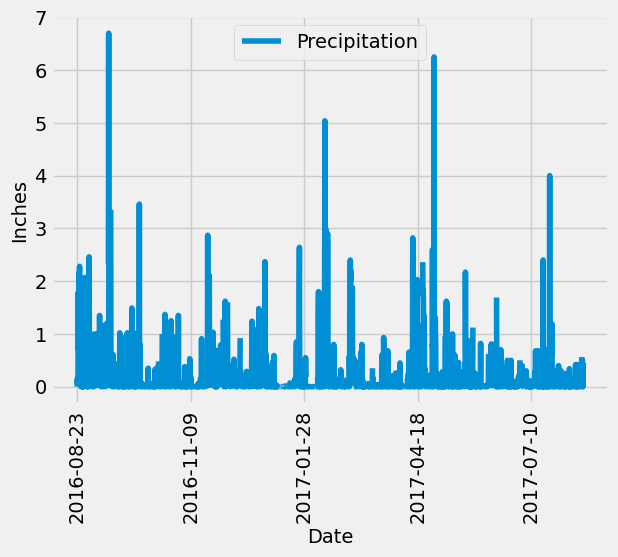

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values(by='Date', ascending=True, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(x='Date', y='Precipitation', rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()






In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print("Total number of stations in the dataset:", total_stations)

Total number of stations in the dataset: 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
                         .group_by(Measurement.station) \
                         .order_by(func.count(Measurement.station).desc()) \
                         .all()
print("Most active stations (in descending order of row counts):")
for station, row_count in active_stations:
    print(f"Station: {station}, Row Count: {row_count}")


Most active stations (in descending order of row counts):
Station: USC00519281, Row Count: 2772
Station: USC00519397, Row Count: 2724
Station: USC00513117, Row Count: 2709
Station: USC00519523, Row Count: 2669
Station: USC00516128, Row Count: 2612
Station: USC00514830, Row Count: 2202
Station: USC00511918, Row Count: 1979
Station: USC00517948, Row Count: 1372
Station: USC00518838, Row Count: 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = session.query(Measurement.station, func.count(Measurement.station)) \
                            .group_by(Measurement.station) \
                            .order_by(func.count(Measurement.station).desc()) \
                            .first()

if most_active_station:
    # Unpack the station name from the query result
    most_active_station = most_active_station[0]

    # Query to calculate the lowest, highest, and average temperature for the most active station
    results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                     .filter(Measurement.station == most_active_station) \
                     .first()

    if results:
        lowest_temp, highest_temp, average_temp = results

        # Print the results
        print(f"Most active station: {most_active_station}")
        print(f"Lowest Temperature: {lowest_temp} F")
        print(f"Highest Temperature: {highest_temp} F")
        print(f"Average Temperature: {average_temp:.2f} F")
    else:
        print("No temperature data found for the most active station.")
else:
    print("No data found for any station.")


Most active station: USC00519281
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66 F


Text(0.5, 4.183333333333314, 'Temperature')

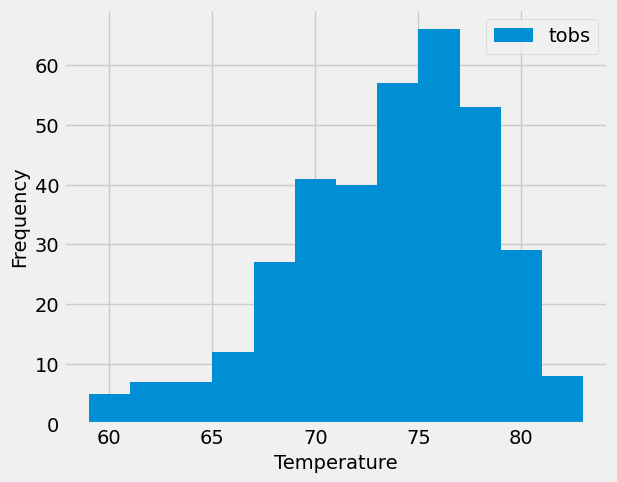

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")

# Close Session

In [ ]:
# Close Session
session.close()

In [23]:
#!pip install Flask

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import MetaData

In [24]:
# Import required libraries
import datetime as dt
import numpy as np
import pandas as pd

from flask import Flask, jsonify

# Create an app
app = Flask(__name__)

# Define the home page route
@app.route('/')
def home():
    return (
        f"Welcome to the Climate App API!<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/&lt;start&gt;<br/>"
        f"/api/v1.0/&lt;start&gt;/&lt;end&gt;<br/>"
    )

# Define the precipitation route
@app.route('/api/v1.0/precipitation')
def precipitation():
    # Perform the precipitation analysis and retrieve data for the last 12 months
    
    last_12_months_data = retrieve_last_12_months_data() 

    # Convert the data to a dictionary with date as the key and prcp as the value
    prcp_dict = {date: prcp for date, prcp in last_12_months_data}

    return jsonify(prcp_dict)

# Define the stations route
@app.route('/api/v1.0/stations')
def stations():
    
    stations_list = retrieve_stations()

    return jsonify(stations_list)

# Define the temperature observations route
@app.route('/api/v1.0/tobs')
def tobs():
   #get the most-active station's temperature observations for the previous year
    temp_observations = retrieve_most_active_station_temps()

    return jsonify(temp_observations)

# Define the start and start-end range route
@app.route('/api/v1.0/<start>')
@app.route('/api/v1.0/<start>/<end>')
def temp_summary(start, end=None):
    
    if end:
        temp_summary_data = retrieve_temp_summary_with_end_date(start, end)
    else:
        temp_summary_data = retrieve_temp_summary(start)

    return jsonify(temp_summary_data)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1